<a href="https://colab.research.google.com/github/njucs/notebook/blob/master/Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Attention**
参考：\
https://wmathor.com/index.php/archives/1450/ \
https://wmathor.com/index.php/archives/1451/

# Seq2Seq with Attention 的 PyTorch 实现（机器翻译）

## Preparing Data

Again, the preparation is similar to last time.

First we import all the required modules.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

Set the random seeds for reproducability.

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Load the German and English spaCy models.

In [ ]:
! python -m spacy download de
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

We create the tokenizers.

In [ ]:
def tokenize_de(text):
    # Tokenizes German text from a string into a list of strings
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    # Tokenizes English text from a string into a list of strings
    return [tok.text for tok in spacy_en.tokenizer(text)]

The fields remain the same as before.

In [ ]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

**加载数据。**输入的每个句子开头和结尾都带有特殊的标识符。对于每个 batch 内的句子，将它们的长度通过加 <PAD> 变得一样，即一个 batch 内的句子，长度都是相同的，不同 batch 内的句子长度不一定相同。

In [ ]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'),fields = (SRC, TRG))

**构建词库。**需要将源句子和目标句子分开构建字典，也就是单独对德语构建一个词库，对英语构建一个词库。

In [ ]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

Define the device.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Create the iterators.

In [ ]:
BATCH_SIZE = 128
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

## Building the Seq2Seq Model

### Encoder



In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src): 
        '''
        src = [src_len, batch_size]
        '''
        src = src.transpose(0, 1) # src = [batch_size, src_len]
        embedded = self.dropout(self.embedding(src)).transpose(0, 1) # embedded = [src_len, batch_size, emb_dim]
        
        # enc_output = [src_len, batch_size, hid_dim * num_directions]
        # enc_hidden = [n_layers * num_directions, batch_size, hid_dim]
        enc_output, enc_hidden = self.rnn(embedded) # if h_0 is not give, it will be set 0 acquiescently

        # enc_hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        # enc_output are always from the last layer
        
        # enc_hidden [-2, :, : ] is the last of the forwards RNN 
        # enc_hidden [-1, :, : ] is the last of the backwards RNN
        
        # initial decoder hidden is final hidden state of the forwards and backwards 
        # encoder RNNs fed through a linear layer
        # s = [batch_size, dec_hid_dim]
        s = torch.tanh(self.fc(torch.cat((enc_hidden[-2,:,:], enc_hidden[-1,:,:]), dim = 1)))
        
        return enc_output, s

### Attention


In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim, bias=False)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, s, enc_output):
        
        # s = [batch_size, dec_hid_dim]
        # enc_output = [src_len, batch_size, enc_hid_dim * 2]
        
        batch_size = enc_output.shape[1]
        src_len = enc_output.shape[0]
        
        # repeat decoder hidden state src_len times
        # s = [batch_size, src_len, dec_hid_dim]
        # enc_output = [batch_size, src_len, enc_hid_dim * 2]
        s = s.unsqueeze(1).repeat(1, src_len, 1)
        enc_output = enc_output.transpose(0, 1)
        
        # energy = [batch_size, src_len, dec_hid_dim]
        energy = torch.tanh(self.attn(torch.cat((s, enc_output), dim = 2)))
        
        # attention = [batch_size, src_len]
        attention = self.v(energy).squeeze(2)
        
        return F.softmax(attention, dim=1)

### Decoder


In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, dec_input, s, enc_output):
             
        # dec_input = [batch_size]
        # s = [batch_size, dec_hid_dim]
        # enc_output = [src_len, batch_size, enc_hid_dim * 2]
        
        dec_input = dec_input.unsqueeze(1) # dec_input = [batch_size, 1]
        
        embedded = self.dropout(self.embedding(dec_input)).transpose(0, 1) # embedded = [1, batch_size, emb_dim]
        
        # a = [batch_size, 1, src_len]  
        a = self.attention(s, enc_output).unsqueeze(1)
        
        # enc_output = [batch_size, src_len, enc_hid_dim * 2]
        enc_output = enc_output.transpose(0, 1)

        # c = [1, batch_size, enc_hid_dim * 2]
        c = torch.bmm(a, enc_output).transpose(0, 1)

        # rnn_input = [1, batch_size, (enc_hid_dim * 2) + emb_dim]
        rnn_input = torch.cat((embedded, c), dim = 2)
            
        # dec_output = [src_len(=1), batch_size, dec_hid_dim]
        # dec_hidden = [n_layers * num_directions, batch_size, dec_hid_dim]
        dec_output, dec_hidden = self.rnn(rnn_input, s.unsqueeze(0))
        
        # embedded = [batch_size, emb_dim]
        # dec_output = [batch_size, dec_hid_dim]
        # c = [batch_size, enc_hid_dim * 2]
        embedded = embedded.squeeze(0)
        dec_output = dec_output.squeeze(0)
        c = c.squeeze(0)
        
        # pred = [batch_size, output_dim]
        pred = self.fc_out(torch.cat((dec_output, c, embedded), dim = 1))
        
        return pred, dec_hidden.squeeze(0)

### Seq2Seq


In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        # src = [src_len, batch_size]
        # trg = [trg_len, batch_size]
        # teacher_forcing_ratio is probability to use teacher forcing
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # enc_output is all hidden states of the input sequence, back and forwards
        # s is the final forward and backward hidden states, passed through a linear layer
        enc_output, s = self.encoder(src)
                
        # first input to the decoder is the <sos> tokens
        dec_input = trg[0,:]
        
        for t in range(1, trg_len):
            
            # insert dec_input token embedding, previous hidden state and all encoder hidden states
            # receive output tensor (predictions) and new hidden state
            dec_output, s = self.decoder(dec_input, s, enc_output)
            
            # place predictions in a tensor holding predictions for each token
            outputs[t] = dec_output
            
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            # get the highest predicted token from our predictions
            top1 = dec_output.argmax(1) 
            
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            dec_input = trg[t] if teacher_force else top1

        return outputs

## Training the Seq2Seq Model

The rest of this tutorial is very similar to the previous one.

We initialise our parameters, encoder, decoder and seq2seq model (placing it on the GPU if we have one). 

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

We then create the training loop...

In [ ]:
def train(model, iterator, optimizer, criterion):
    model.train()    
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg # trg = [trg_len, batch_size]

        # pred = [trg_len, batch_size, pred_dim]
        pred = model(src, trg)
        
        pred_dim = pred.shape[-1]
        
        # trg = [(trg len - 1) * batch size]
        # pred = [(trg len - 1) * batch size, pred_dim]
        trg = trg[1:].view(-1)
        pred = pred[1:].view(-1, pred_dim)
        
        loss = criterion(pred, trg)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
  
    return epoch_loss / len(iterator)

...and the evaluation loop, remembering to set the model to `eval` mode and turn off teaching forcing.

In [ ]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg # trg = [trg_len, batch_size]

            # output = [trg_len, batch_size, output_dim]
            output = model(src, trg, 0) # turn off teacher forcing
          
            output_dim = output.shape[-1]
            
            # trg = [(trg_len - 1) * batch_size]
            # output = [(trg_len - 1) * batch_size, output_dim]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

Finally, define a timing function.

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Then, we train our model, saving the parameters that give us the best validation loss.

In [ ]:
best_valid_loss = float('inf')

for epoch in range(10):
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 2m 40s
	Train Loss: 4.346 | Train PPL:  77.152
	 Val. Loss: 3.636 |  Val. PPL:  37.924
Epoch: 02 | Time: 2m 41s
	Train Loss: 3.114 | Train PPL:  22.511
	 Val. Loss: 3.281 |  Val. PPL:  26.606
Epoch: 03 | Time: 2m 40s
	Train Loss: 2.653 | Train PPL:  14.192
	 Val. Loss: 3.304 |  Val. PPL:  27.221
Epoch: 04 | Time: 2m 41s
	Train Loss: 2.355 | Train PPL:  10.536
	 Val. Loss: 3.269 |  Val. PPL:  26.282
Epoch: 05 | Time: 2m 40s
	Train Loss: 2.136 | Train PPL:   8.464
	 Val. Loss: 3.279 |  Val. PPL:  26.548
Epoch: 06 | Time: 2m 42s
	Train Loss: 1.995 | Train PPL:   7.350
	 Val. Loss: 3.292 |  Val. PPL:  26.895
Epoch: 07 | Time: 2m 40s
	Train Loss: 1.881 | Train PPL:   6.563
	 Val. Loss: 3.261 |  Val. PPL:  26.070
Epoch: 08 | Time: 2m 40s
	Train Loss: 1.780 | Train PPL:   5.928
	 Val. Loss: 3.332 |  Val. PPL:  27.984
Epoch: 09 | Time: 2m 41s
	Train Loss: 1.693 | Train PPL:   5.434
	 Val. Loss: 3.360 |  Val. PPL:  28.796
Epoch: 10 | Time: 2m 40s
	Train Loss: 1.656 | Train PPL

Finally, we test the model on the test set using these "best" parameters.

In [ ]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.337 | Test PPL:  28.140 |


# **一个简化的例子**

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0400 cost = 0.000522
Epoch: 0800 cost = 0.000170
Epoch: 1200 cost = 0.000084
Epoch: 1600 cost = 0.000050
Epoch: 2000 cost = 0.000033
ich mochte ein bier P -> ['i', 'want', 'a', 'beer', 'E']


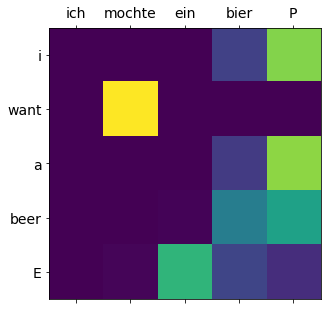

In [1]:
# code by Tae Hwan Jung @graykode
# Reference : https://github.com/hunkim/PyTorchZeroToAll/blob/master/14_2_seq2seq_att.py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps
# [seq_len, batch_size]，一个 batch 内的句子，长度都是相同的，不同 batch 内的句子长度不一定相同

def make_batch():
    input_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[0].split()]]]
    output_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[1].split()]]]
    target_batch = [[word_dict[n] for n in sentences[2].split()]]

    # make tensor
    return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)

class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
        self.dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)

        # Linear for attention
        self.attn = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden * 2, n_class)

    def forward(self, enc_inputs, hidden, dec_inputs):
        enc_inputs = enc_inputs.transpose(0, 1)  # enc_inputs: [n_step(=n_step, time step), batch_size, n_class]
        dec_inputs = dec_inputs.transpose(0, 1)  # dec_inputs: [n_step(=n_step, time step), batch_size, n_class]

        # enc_outputs : [n_step, batch_size, num_directions(=1) * n_hidden], matrix F
        # enc_hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        enc_outputs, enc_hidden = self.enc_cell(enc_inputs, hidden)

        trained_attn = []
        hidden = enc_hidden
        n_step = len(dec_inputs)
        model = torch.empty([n_step, 1, n_class])

        for i in range(n_step):  # each time step
            # dec_output : [n_step(=1), batch_size(=1), num_directions(=1) * n_hidden]
            # hidden : [num_layers(=1) * num_directions(=1), batch_size(=1), n_hidden]
            dec_output, hidden = self.dec_cell(dec_inputs[i].unsqueeze(0), hidden)
            attn_weights = self.get_att_weight(dec_output, enc_outputs)  # attn_weights : [1, 1, n_step]
            trained_attn.append(attn_weights.squeeze().data.numpy())

            # matrix-matrix product of matrices [1,1,n_step] x [1,n_step,n_hidden] = [1,1,n_hidden]
            context = attn_weights.bmm(enc_outputs.transpose(0, 1))
            dec_output = dec_output.squeeze(0)  # dec_output : [batch_size(=1), num_directions(=1) * n_hidden]
            context = context.squeeze(1)  # [1, num_directions(=1) * n_hidden]
            model[i] = self.out(torch.cat((dec_output, context), 1))

        # make model shape [n_step, n_class]
        return model.transpose(0, 1).squeeze(0), trained_attn

    def get_att_weight(self, dec_output, enc_outputs):  # get attention weight one 'dec_output' with 'enc_outputs'
        n_step = len(enc_outputs)
        attn_scores = torch.zeros(n_step)  # attn_scores : [n_step]

        for i in range(n_step):
            attn_scores[i] = self.get_att_score(dec_output, enc_outputs[i])

        # Normalize scores to weights in range 0 to 1
        return F.softmax(attn_scores).view(1, 1, -1)

    def get_att_score(self, dec_output, enc_output):  # enc_outputs [batch_size, num_directions(=1) * n_hidden]
        score = self.attn(enc_output)  # score : [batch_size, n_hidden]
        return torch.dot(dec_output.view(-1), score.view(-1))  # inner product make scalar value

if __name__ == '__main__':
    n_step = 5 # number of cells(= number of Step)
    n_hidden = 128 # number of hidden units in one cell

    # 实际操作中，在数据预处理的时候，需要将源句子和目标句子分开构建字典
    # 也就是单独对源语言构建一个词库，对目标语言构建一个词库
    sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']
    word_list = " ".join(sentences).split()
    word_list = list(set(word_list))
    word_dict = {w: i for i, w in enumerate(word_list)}
    number_dict = {i: w for i, w in enumerate(word_list)}
    n_class = len(word_dict)  # vocab list

    # hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
    hidden = torch.zeros(1, 1, n_hidden)

    model = Attention()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    input_batch, output_batch, target_batch = make_batch()

    # Train
    for epoch in range(2000):
        optimizer.zero_grad()
        output, _ = model(input_batch, hidden, output_batch)

        loss = criterion(output, target_batch.squeeze(0))
        if (epoch + 1) % 400 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

        loss.backward()
        optimizer.step()

    # Test
    test_batch = [np.eye(n_class)[[word_dict[n] for n in 'SPPPP']]]
    test_batch = torch.FloatTensor(test_batch)
    predict, trained_attn = model(input_batch, hidden, test_batch)
    predict = predict.data.max(1, keepdim=True)[1]
    print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

    # Show Attention
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(trained_attn, cmap='viridis')
    ax.set_xticklabels([''] + sentences[0].split(), fontdict={'fontsize': 14})
    ax.set_yticklabels([''] + sentences[2].split(), fontdict={'fontsize': 14})
    plt.show()